#**단기예측 모델 설계 방향**
**1. 재실인원 데이터 추가한 다변량 단기 모델(온도, 재실인원)**  
재실 인원을 카메라로 예측한 데이터로 모델 설계
- 다변량 단기 예측 모델
 - 재실인원 추가
 - 다변량모델 (온도, 재실인원)
 - 기본 모델인 LSTM으로 인원 예측이 잘 되는지 먼저 확인

- 50분 데이터로 10분 예측
  
- 예측이 잘된다면 다른 모델로 변경하여 예측할 계획

1분 단위 리샘플링

In [1]:
!pip install PyMySQL

     |████████████████████████████████| 43 kB 587 kB/s 


In [2]:
import pymysql

In [3]:
occupancy_db = pymysql.connect(
    user='datacollection', 
    passwd='collection2021!@', 
    host='121.156.90.144', 
    db='db_datacollection', 
    charset='utf8'
)

In [4]:
cursor = occupancy_db.cursor(pymysql.cursors.DictCursor)

In [5]:
sql = "Show Tables;"
cursor.execute(sql)
show = cursor.fetchall()
show

[{'Tables_in_db_datacollection': 'dc_building'},
 {'Tables_in_db_datacollection': 'dc_device'},
 {'Tables_in_db_datacollection': 'dc_floor'},
 {'Tables_in_db_datacollection': 'dc_long_term'},
 {'Tables_in_db_datacollection': 'dc_people_cnt'},
 {'Tables_in_db_datacollection': 'dc_pro_mode_define'},
 {'Tables_in_db_datacollection': 'dc_pro_module'},
 {'Tables_in_db_datacollection': 'dc_sensor'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_arduino_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_arduino_1_name'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_composite_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_temp_camera_1'},
 {'Tables_in_db_datacollection': 'dc_sensor_data_temp_camera_info'},
 {'Tables_in_db_datacollection': 'dc_sensor_define'},
 {'Tables_in_db_datacollection': 'dc_server'},
 {'Tables_in_db_datacollection': 'dc_short_term'},
 {'Tables_in_db_datacollection': 'dc_spot'},
 {'Tables_in_db_datacollection': 'dc_unit_define'},
 {'Tables_in_db_datacollec

In [6]:
sql = "SELECT sdata_credate, sdata_temp FROM vw_data_composite WHERE sdata_modbus_id=1;"
cursor.execute(sql)
data = cursor.fetchall()

In [7]:
# tcl_idx, tci_idx, people, changepeople, reg_dte 
sql1 = "SELECT changepeople, reg_dte FROM se_device_temp_cam_log1;"
cursor.execute(sql1)
data1 = cursor.fetchall()

In [8]:
# tcl_idx, tci_idx, people, changepeople, reg_dte 
sql2 = "SELECT * FROM se_device_temp_cam_log1;"
cursor.execute(sql2)
data2 = cursor.fetchall()

In [9]:
import pandas as pd

data = pd.DataFrame(data)
data1 = pd.DataFrame(data1)

In [10]:
# data.to_csv('occupancy_co2_20220217.csv')
# data2.to_csv('occupancy_all_20220222.csv')

In [11]:
data.rename(columns={'sdata_credate': 'datetime'},inplace=True)
data1.rename(columns={'reg_dte': 'datetime'},inplace=True)

In [12]:
data['datetime'] = pd.to_datetime(data['datetime'])
data1['datetime'] = pd.to_datetime(data1['datetime'])

In [13]:
data.set_index('datetime', inplace=True)
data1.set_index('datetime', inplace=True)

In [14]:
data = data.resample('1T').first()
data=data.loc['2022-02-11 16:32:00':]

In [15]:
print(data)
print(data1)

                     sdata_temp
datetime                       
2022-02-11 16:32:00       25.38
2022-02-11 16:33:00       25.33
2022-02-11 16:34:00       25.29
2022-02-11 16:35:00       25.27
2022-02-11 16:36:00       25.21
...                         ...
2022-02-28 16:23:00       25.91
2022-02-28 16:24:00       25.92
2022-02-28 16:25:00       25.92
2022-02-28 16:26:00       25.96
2022-02-28 16:27:00       25.96

[24476 rows x 1 columns]
                     changepeople
datetime                         
2022-02-11 16:32:00             0
2022-02-11 16:33:00             0
2022-02-11 17:11:00             0
2022-02-11 17:12:00             0
2022-02-11 17:13:00             0
...                           ...
2022-02-28 16:24:00             6
2022-02-28 16:25:00             6
2022-02-28 16:26:00             6
2022-02-28 16:27:00             6
2022-02-28 16:28:00             6

[20206 rows x 1 columns]


In [16]:
merge_df = pd.merge(data, data1, left_index=True, right_index=True, how='left')
merge_df

,sdata_temp,changepeople
datetime,,
2022-02-11 16:32:00,25.38,0.0
2022-02-11 16:33:00,25.33,0.0
2022-02-11 16:34:00,25.29,NaN
2022-02-11 16:35:00,25.27,NaN
2022-02-11 16:36:00,25.21,NaN
...,...,...
2022-02-28 16:23:00,25.91,6.0
2022-02-28 16:24:00,25.92,6.0
2022-02-28 16:25:00,25.92,6.0


In [17]:
merge_df.fillna(0, inplace=True)

In [18]:
merge_df['changepeople'].value_counts()

 0.0     12258
-1.0      3885
 1.0      1826
-2.0      1252
 5.0      1112
 7.0       944
 6.0       831
 4.0       631
 3.0       535
 2.0       473
 8.0       358
 9.0       177
 10.0      117
 12.0       51
 11.0       26
Name: changepeople, dtype: int64

In [19]:
# 인원 수가 마이너스가 나온 경우, 0으로 맞춰줌
for i in range(len(merge_df)):
    if merge_df['changepeople'][i]< 0:
        merge_df['changepeople'][i]=0

In [20]:
merge_df['changepeople'].value_counts()

0.0     17395
1.0      1826
5.0      1112
7.0       944
6.0       831
4.0       631
3.0       535
2.0       473
8.0       358
9.0       177
10.0      117
12.0       51
11.0       26
Name: changepeople, dtype: int64

# 카메라 기반 재실 데이터 그래프
- 온도, 재실인원

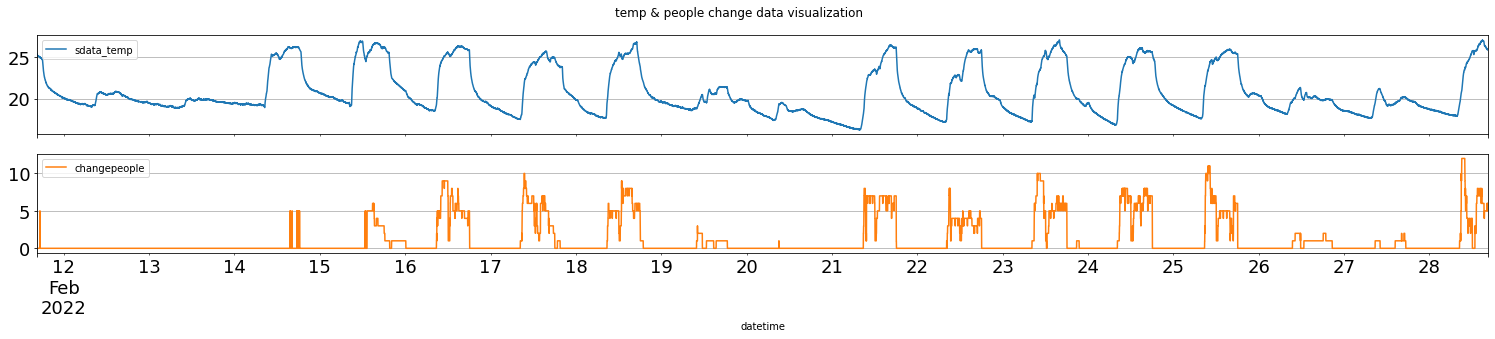

In [21]:
import matplotlib.pyplot as plt

merge_df.plot(subplots=True, grid=True, 
           figsize=(26, 4), fontsize=18,
           title='temp & people change data visualization')
plt.show()

## 온도 데이터로 단변량 예측

In [22]:
from keras.models import load_model
import numpy as np

In [23]:
# 재실밀도 데이터
df = merge_df
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [24]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [25]:
w1 = WindowGenerator(input_width=50, label_width=1, shift=50,
                         label_columns=['sdata_temp', 'changepeople'])

In [26]:
w2 = WindowGenerator(input_width=10, label_width=1, shift=1,
                         label_columns=['sdata_temp','changepeople'])

In [27]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [28]:
import tensorflow as tf

# Stack three slices, the length of the total window:
window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

inputs, labels = w2.split_window(window)

print('Temperature shapes are: (batch, time, features)')
print(f'Window shape: {window.shape}')
print(f'Inputs shape: {inputs.shape}')
print(f'labels shape: {labels.shape}\n')

Temperature shapes are: (batch, time, features)
Window shape: (3, 11, 2)
Inputs shape: (3, 10, 2)
labels shape: (3, 1, 2)



In [29]:
w2.example = inputs, labels

In [30]:
# temp
def temp_plot(self, model=None, plot_col='sdata_temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(20, 10))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [1m]')

WindowGenerator.temp_plot = temp_plot

# change people
def changepeople_plot(self, model=None, plot_col='changepeople', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(20, 10))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [1m]')

WindowGenerator.changepeople_plot = changepeople_plot

In [31]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [32]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [33]:
w2.train.element_spec

(TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))

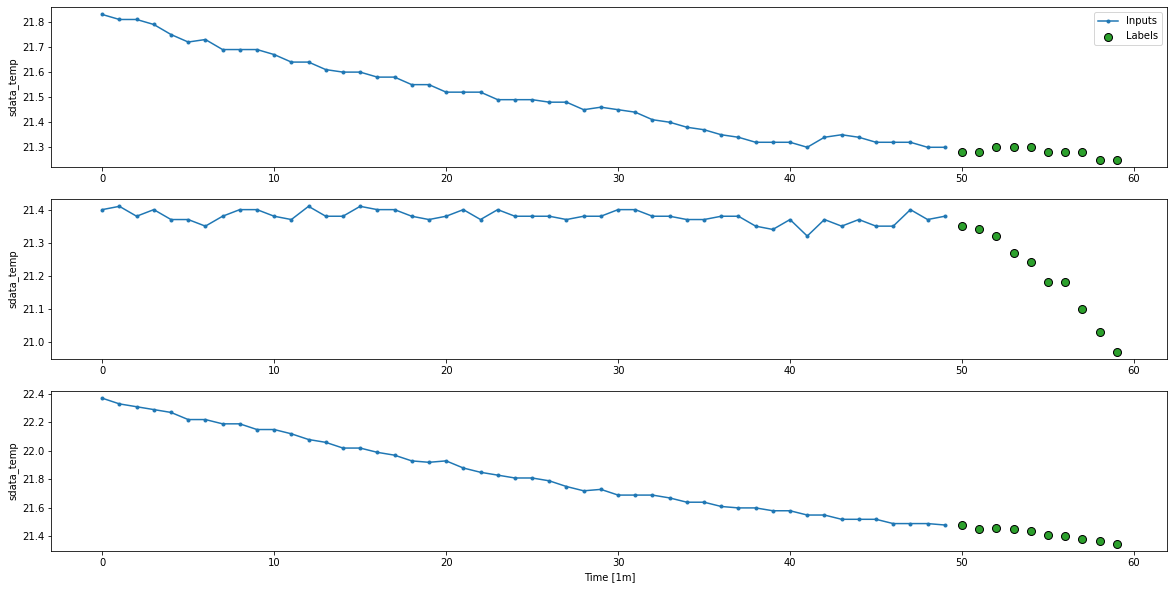

In [34]:
OUT_STEPS=10
multi_window = WindowGenerator(input_width=50,
                                   label_width=OUT_STEPS,
                                   shift=OUT_STEPS)

multi_window
multi_window.temp_plot()

In [35]:
print(len(multi_window.train))
print(len(multi_window.val))
print(len(multi_window.test))

534
152
75


In [36]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### 온도

Epoch 1/100
346/346 [==============================] - 30s 77ms/step - loss: 43.8377 - mean_absolute_error: 4.0717 - val_loss: 5.8485 - val_mean_absolute_error: 1.8967
Epoch 2/100
346/346 [==============================] - 18s 52ms/step - loss: 5.8793 - mean_absolute_error: 1.8968 - val_loss: 6.0967 - val_mean_absolute_error: 1.9109
Epoch 3/100
346/346 [==============================] - 18s 52ms/step - loss: 3.9027 - mean_absolute_error: 1.4306 - val_loss: 1.9605 - val_mean_absolute_error: 0.8844
Epoch 4/100
346/346 [==============================] - 19s 54ms/step - loss: 1.0077 - mean_absolute_error: 0.5886 - val_loss: 0.8749 - val_mean_absolute_error: 0.6035
Epoch 5/100
346/346 [==============================] - 20s 56ms/step - loss: 0.4844 - mean_absolute_error: 0.3687 - val_loss: 0.6187 - val_mean_absolute_error: 0.4613
Epoch 6/100
346/346 [==============================] - 20s 56ms/step - loss: 0.2946 - mean_absolute_error: 0.2735 - val_loss: 0.3572 - val_mean_absolute_error: 0.33

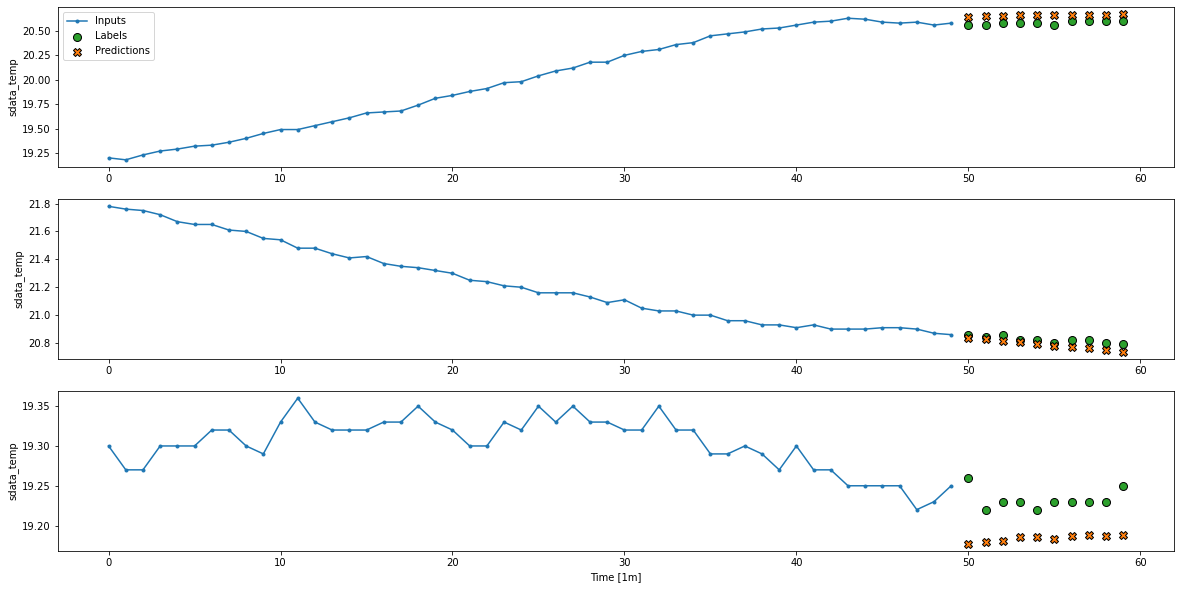

In [ ]:
temp_multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

temp_history = compile_and_fit(temp_multi_lstm_model, multi_window)

temp_multi_val_performance = {}
temp_multi_performance = {}
temp_multi_val_performance['LSTM'] = temp_multi_lstm_model.evaluate(multi_window.val)
temp_multi_performance['LSTM'] = temp_multi_lstm_model.evaluate(multi_window.test, verbose=0)

multi_window.temp_plot(temp_multi_lstm_model)

In [ ]:
temp_multi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
 reshape (Reshape)           (None, 10, 2)             0         
                                                                 
Total params: 69,652
Trainable params: 69,652
Non-trainable params: 0
_________________________________________________________________


In [ ]:
temp_multi_lstm_model.evaluate(multi_window.test)

48/48 [==============================] - 1s 18ms/step - loss: 0.2483 - mean_absolute_error: 0.1907


[0.24825698137283325, 0.1906629204750061]

In [ ]:
print('_________________________________________________________________')
print('Model evaluate')
print('=================================================================')
print('Loss: ', temp_multi_performance['LSTM'][0])
print('MAE(Mean Absolute Error): ', temp_multi_performance['LSTM'][1])
print('=================================================================')

_________________________________________________________________
Model evaluate
Loss:  0.24825702607631683
MAE(Mean Absolute Error):  0.1906629353761673


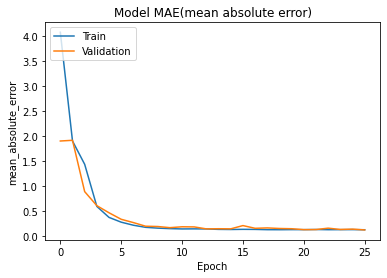

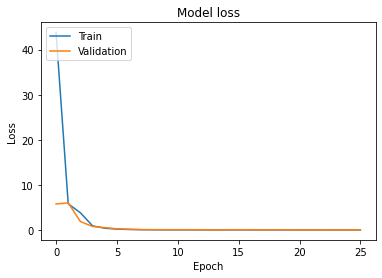

In [ ]:
# 6 훈련 과정 시각화 (MAE)
plt.plot(temp_history.history['mean_absolute_error'])
plt.plot(temp_history.history['val_mean_absolute_error'])
plt.title('Model MAE(mean absolute error)')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(temp_history.history['loss'])
plt.plot(temp_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# # 모델 저장
# temp_multi_lstm_model.save('temp_multi_lstm_model.h5')

In [ ]:
changepeople_multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

changepeople_history = compile_and_fit(changepeople_multi_lstm_model, multi_window)

changepeople_multi_val_performance = {}
changepeople_multi_performance = {}
changepeople_multi_val_performance['LSTM'] = changepeople_multi_lstm_model.evaluate(multi_window.val)
changepeople_multi_performance['LSTM'] = changepeople_multi_lstm_model.evaluate(multi_window.test, verbose=0)


Epoch 1/100
346/346 [==============================] - 21s 53ms/step - loss: 43.7538 - mean_absolute_error: 4.0629 - val_loss: 5.8508 - val_mean_absolute_error: 1.9038
Epoch 2/100
346/346 [==============================] - 18s 52ms/step - loss: 5.8780 - mean_absolute_error: 1.8944 - val_loss: 5.9121 - val_mean_absolute_error: 1.9672
Epoch 3/100
346/346 [==============================] - 18s 52ms/step - loss: 3.7792 - mean_absolute_error: 1.3946 - val_loss: 1.3520 - val_mean_absolute_error: 0.7079
Epoch 4/100
346/346 [==============================] - 18s 51ms/step - loss: 0.8808 - mean_absolute_error: 0.5310 - val_loss: 0.5854 - val_mean_absolute_error: 0.4380
Epoch 5/100
346/346 [==============================] - 18s 51ms/step - loss: 0.3457 - mean_absolute_error: 0.3030 - val_loss: 0.3471 - val_mean_absolute_error: 0.3544
Epoch 6/100
346/346 [==============================] - 18s 52ms/step - loss: 0.1977 - mean_absolute_error: 0.2164 - val_loss: 0.2394 - val_mean_absolute_error: 0.28

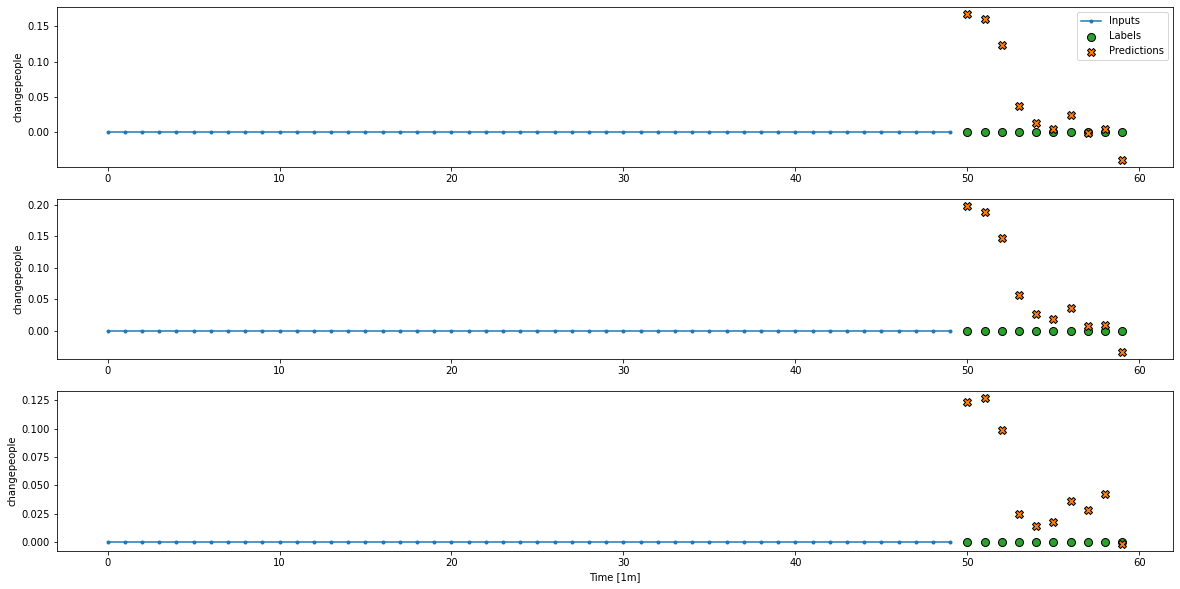

In [ ]:
multi_window.changepeople_plot(changepeople_multi_lstm_model)

In [ ]:
changepeople_multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67072     
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
 reshape_1 (Reshape)         (None, 10, 2)             0         
                                                                 
Total params: 69,652
Trainable params: 69,652
Non-trainable params: 0
_________________________________________________________________


In [ ]:
changepeople_multi_lstm_model.evaluate(multi_window.test)

48/48 [==============================] - 1s 18ms/step - loss: 0.2632 - mean_absolute_error: 0.2321


[0.26316192746162415, 0.23210661113262177]

In [ ]:
print('_________________________________________________________________')
print('Model evaluate')
print('=================================================================')
print('Loss: ', changepeople_multi_performance['LSTM'][0])
print('MAE(Mean Absolute Error): ', changepeople_multi_performance['LSTM'][1])
print('=================================================================')

_________________________________________________________________
Model evaluate
Loss:  0.26316189765930176
MAE(Mean Absolute Error):  0.23210661113262177


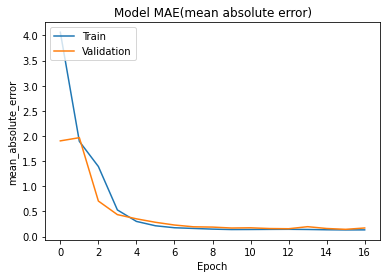

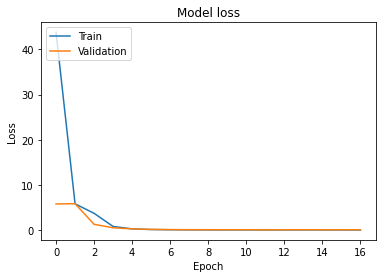

In [ ]:
# 6 훈련 과정 시각화 (MAE)
plt.plot(changepeople_history.history['mean_absolute_error'])
plt.plot(changepeople_history.history['val_mean_absolute_error'])
plt.title('Model MAE(mean absolute error)')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(changepeople_history.history['loss'])
plt.plot(changepeople_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# # 모델 저장
# changepeople_multi_lstm_model.save('temp_changepeople_multi_lstm_model.h5')